<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_6_4_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exercise 6.4**

MNIST with fully connected networks and grid/random search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers

The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:

x_train = x_train / 255.0
y_train = y_train / 255.0
x_test = x_test / 255.0
y_test = y_test / 255.0

x_valid = x_test[8000:]
y_valid = y_test[8000:]
x_test = x_test[:8000]
y_test = y_test[:8000]

# Hint: convert integer RGB values (0-255) to float values (0-1)

In [4]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

In [5]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2)
x_valid = x_valid.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)
print("x_train shape:", x_train.shape)

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a "zero" is encoded as `[1,0,0,0,0,0,0,0,0,0]` and a "one" as `[0,1,0,0,0,0,0,0,0,0]` etc.
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [6]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [7]:
# define model here
model = tf.keras.models.Sequential([
    layers.Dense(128, input_dim=784, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10),
    layers.Activation('softmax')])  # softmax actication to transform output into probabiliites

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
model.compile(
    loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
    optimizer="adam",
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.weights.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

# Keras calculates training accuracy and loss during the training and with regularization applied,
# while the validation metrics are calculated at the end of each epoch.
# This callback calculates the training metrics the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0)
        logs["train_loss"] = train_loss
        logs["train_acc"] = train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),

    batch_size=1,
    epochs=10,
    callbacks=[
        save_best,
        CalculateMetrics(),
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
    ]
    )

Epoch 1/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - train_loss: 0.0000e+00 - train_acc: 1.0000
Epoch 2/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - accuracy: 1.0000 - loss: 3.6119e-12 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - train_loss: 0.0000e+00 - train_acc: 1.0000
Epoch 3/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 1.0000 - loss: 1.9620e-11 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - train_loss: 0.0000e+00 - train_acc: 1.0000
Epoch 4/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 141s 2ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - train_loss: 0.0000e+00 - train_acc: 1.0000
Epoch 5/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 98s 2ms/step - accuracy: 1.0000 - loss: 3.2446e-11 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - train_loss: 0.0000e+00 - train_acc: 1.0000
Epoch 6/10
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - accuracy: 1.

In [1]:
# load best model
model.load_weights(f"best_model_{model.name}.weights.h5")

# ------------------------
# ---     Plotting     ---
# ------------------------

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)
# add plots below


NameError: name 'model' is not defined

In [10]:
# evaluate performance

print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    ["Train", *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Validation", *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Test", *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1])*100 ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |   Loss |   Accuracy |   Test error rate [%] |
|------------+--------+------------+-----------------------|
| Train      |      0 |          1 |                     0 |
| Validation |      0 |          1 |                     0 |
| Test       |      0 |          1 |                     0 |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [12]:
#@title
def plot_image(X, ax=None):
    """Plot an image X.

    Args:
        X (2D array): image, grayscale or RGB
        ax (None, optional): Description
    """
    if ax is None:
        ax = plt.gca()

    if (X.ndim == 2) or (X.shape[-1] == 1):
        ax.imshow(X.astype('uint8'), origin='upper', cmap=plt.cm.Greys)
    else:
        ax.imshow(X.astype('uint8'), origin='upper')

    ax.set(xticks=[], yticks=[])

def plot_prediction(Yp, X, y, classes=None, top_n=False):
    """Plot an image along with all or the top_n predictions.

    Args:
        Yp (1D array): predicted probabilities for each class
        X (2D array): image
        y (integer): true class label
        classes (1D array, optional): class names
        top_n (int, optional): number of top predictions to show
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)
    plot_image(X, ax1)

    if top_n:
        n = top_n
        s = np.argsort(Yp)[-top_n:]
    else:
        n = len(Yp)
        s = np.arange(n)[::-1]

    patches = ax2.barh(np.arange(n), Yp[s], align='center')
    ax2.set(xlim=(0, 1), xlabel='Probability', yticks=[])

    for iy, patch in zip(s, patches):
        if iy == y:
            patch.set_facecolor('C1')  # color correct patch

    if classes is None:
        classes = np.arange(0, np.size(Yp))

    for i in range(n):
        ax2.text(0.05, i, classes[s][i], ha='left', va='center')

    plt.show()

def plot_confusion(yp, y, classes=None, fname=None):
    """Plot confusion matrix for given true and predicted class labels

    Args:
        yp (1D array): predicted class labels
        y (1D array): true class labels
        classes (1D array): class names
        fname (str, optional): filename for saving the plot
    """
    if classes is None:
        n = max(max(yp), max(y)) + 1
        classes = np.arange(n)
    else:
        n = len(classes)

    bins = np.linspace(-0.5, n - 0.5, n + 1)
    C = np.histogram2d(y, yp, bins=bins)[0]
    C = C / np.sum(C, axis=0) * 100

    fig = plt.figure(figsize=(8, 8))
    plt.imshow(C, interpolation='nearest', vmin=0, vmax=100, cmap=plt.cm.YlGnBu)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label('Frequency %')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.xticks(range(n), classes, rotation='vertical')
    plt.yticks(range(n), classes)
    for x in range(n):
        for y in range(n):
            if np.isnan(C[x, y]):
                continue
            color = 'white' if x == y else 'black'
            plt.annotate('%.1f' % (C[x, y]), xy=(y, x), color=color, ha='center', va='center')

    plt.show()

In [14]:
# plot a few examples, loop over test dataset:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


ValueError: `bins[0]` must be positive, when an integer

ValueError: cannot reshape array of size 0 into shape (4,8,28,28)

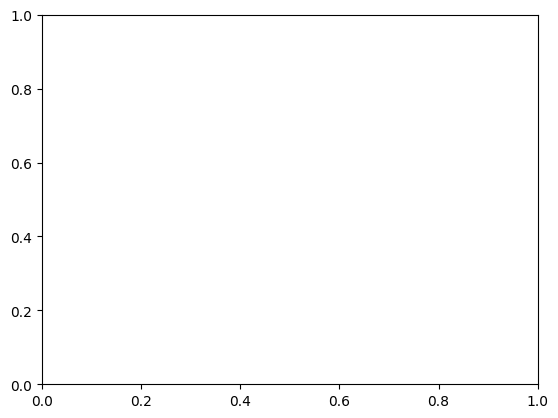

In [15]:
# now plot a few examples that were misclassified

indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# or plot 32 of them in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap="gray")


**Grid search**

Let's search the two hyperparameters dropout and number of nodes. You can start from the template below.



In [ ]:
dropout_values = ...
n_neurons_values = ...
results_gridsearch = np.zeros((len(dropout_values), len(n_neurons_values), 2))
for iDrop, drop in enumerate(dropout_values):
  for iN, n_neurons in enumerate(n_neurons_values):
    model = tf.keras.models.Sequential([
        layers.Dense(, input_shape=(784,)),
        ...
        layers.Dense(10),
        layers.Activation('softmax')])  # softmax actication to transform output into probabiliites

    model.compile(
        loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
        optimizer=...),
        metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

    results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=,
        epochs=10,
        verbose=0
        )
    t = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)
    results_gridsearch[iDrop, iN] = t
    print(f"dropout = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


**Random seach**

Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time. You can start from the template below.




In [ ]:
N = 20 # number of trials
search = {
'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
'learn_rate': np.random.choice([-5,-4, -3, -2, -1],N),
'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(..., input_shape=(784,)),
                      ...
                      tf.keras.layers.Dense(10, activation='softmax')])
  model.compile(loss='categorical_crossentropy',
  optimizer=...
  results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=...,
        epochs=10,
        verbose=0
      )
  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")
